In [1]:
import sys
import numpy as np
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from recommenders.utils.spark_utils import start_or_get_spark

import pandas as pd
import matplotlib.pyplot as plt
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from pyspark.ml.evaluation import RegressionEvaluator

print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Spark version: 3.3.1


<h1>Set up spark context</h1>

In [2]:
# the following settings work well for debugging locally on VM - change when running on a cluster
# set up a giant single executor with many threads and specify memory cap
spark = start_or_get_spark("ALS PySpark", memory="10g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/08 10:48:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setCheckpointDir('./checkpoints')

<h1>Load the dataset</h1>

In [4]:
# Column names for the dataset
COL_USER = "userID"
COL_ITEM = "itemID"
COL_RATING = "rating"
COL_TIMESTAMP = "timestamp"

In [5]:
def load(dataset_name):

    train_path, test_path = '../data/{}/train.csv'.format(dataset_name), '../data/{}/test.csv'.format(dataset_name)

    # Note: The DataFrame-based API for ALS currently only supports integers for user and item ids.
    schema = StructType(
        (
            StructField(COL_USER, IntegerType()),
            StructField(COL_ITEM, IntegerType()),
            StructField(COL_RATING, FloatType()),
            StructField(COL_TIMESTAMP, LongType()),
        )
    )
    # load as spark with defined schema
    train = spark.read.load(train_path, format="csv", header="true", sep=',', schema=schema)
    test = spark.read.load(test_path, format="csv", header="true", sep=',', schema=schema)

    print("N train", train.cache().count())
    print("N test", test.cache().count())
    
    return train, test

<h1>Train ALS</h1>

In [7]:
def init_als(RANK=40, ITER=35):
    header = {
        "userCol": COL_USER,
        "itemCol": COL_ITEM,
        "ratingCol": COL_RATING,
    }

    als = ALS(
        rank=RANK,
        maxIter=ITER,
        implicitPrefs=False,
        regParam=0.08,
        coldStartStrategy='drop',
        nonnegative=True,
        seed=42,
        **header
    )
    return als

In [8]:
class ALS_recsys:
    def __init__(self, name='sas'):
        
        self.als = init_als()
        self.model = None # trained model

        self.train, self.test = load(name)

    def fit(self):
        evaluator = RegressionEvaluator(metricName="rmse", labelCol=COL_RATING, predictionCol="prediction")

        with Timer() as train_time:
            self.model = self.als.fit(self.train)
            predictions = self.model.transform(self.test)
            rmse = evaluator.evaluate(predictions)
            print(f"Root-mean-square error = {rmse}")

        print("Took {} seconds for training.".format(train_time.interval))

    def get_user_recommendations(self):
        userRecs = self.model.recommendForAllUsers(200)

        rows = []
        for row in userRecs.collect():
            for rec in row['recommendations']:
                rows.append([row['userID'], rec['itemID'], rec['rating']])
                
        schema = StructType([
            StructField("userID", IntegerType(), True),
            StructField("itemID", IntegerType(), True),
            StructField("prediction", FloatType(), True)
        ])

        top_k_df = spark.createDataFrame(rows, schema=schema)
        # Show the top_k_df DataFrame
        return top_k_df
    
    def remove_seen(self, spark_df):
        # Remove seen items.
        dfs_pred_exclude_train = spark_df.alias("other").join(
            self.train.alias("train"),
            (spark_df[COL_USER] == self.train[COL_USER]) & (spark_df[COL_ITEM] == self.train[COL_ITEM]),
            how='outer'
        )

        # train.{col_rating} will be null on the previous step, if this pair was not seen before. These are the entries of interest to us.
        top_ex = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{COL_RATING}"].isNull()) \
            .select("other.*")
        
        return top_ex
    
    def recommend(self):

        top_k_df = self.get_user_recommendations()
        top_ex = self.remove_seen(top_k_df)

        return top_k_df, top_ex
    
    def evaluate_ranking(self, test, pred, TOP_K):

        # Needs all the predictions, to calculate Top-K, NDCG, etc.
        rank_eval = SparkRankingEvaluation(test, pred, k = TOP_K, col_user=COL_USER, col_item=COL_ITEM, 
                                    col_rating=COL_RATING, col_prediction="prediction", 
                                    relevancy_method="top_k")
        
        return rank_eval
    
    def evaluate_rating(self, test):
        
        # Generate predicted ratings.
        prediction = self.model.transform(test)
        prediction.cache()

        rating_eval = SparkRatingEvaluation(test, prediction, col_user=COL_USER, col_item=COL_ITEM, 
                                    col_rating=COL_RATING, col_prediction="prediction")
        
        return rating_eval
    
    def get_all_scores(self):
        # get train inc. / train exc. recommendations
        top_k_df, top_ex = self.recommend()
        
        test_ex = self.remove_seen(self.test)

        ### RANKING

        # remove seen
        rank_eval_5 = self.evaluate_ranking(test_ex, top_ex, 5)
        rank_eval_10 = self.evaluate_ranking(test_ex, top_ex, 10)
        rank_eval_50 = self.evaluate_ranking(test_ex, top_ex, 50)

        exc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [rank_eval_5.map_at_k(), rank_eval_10.map_at_k(), rank_eval_50.map_at_k()],
            'NDCG': [rank_eval_5.ndcg_at_k(), rank_eval_10.ndcg_at_k(), rank_eval_50.ndcg_at_k()],
            'Precision': [rank_eval_5.precision_at_k(), rank_eval_10.precision_at_k(), rank_eval_50.precision_at_k()],
            'Recall': [rank_eval_5.recall_at_k(), rank_eval_10.recall_at_k(), rank_eval_50.recall_at_k()],
        })

        # don't remove seen
        rank_eval_5 = self.evaluate_ranking(self.test, top_k_df, 5)
        rank_eval_10 = self.evaluate_ranking(self.test, top_k_df, 10)
        rank_eval_50 = self.evaluate_ranking(self.test, top_k_df, 50)

        inc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [rank_eval_5.map_at_k(), rank_eval_10.map_at_k(), rank_eval_50.map_at_k()],
            'NDCG': [rank_eval_5.ndcg_at_k(), rank_eval_10.ndcg_at_k(), rank_eval_50.ndcg_at_k()],
            'Precision': [rank_eval_5.precision_at_k(), rank_eval_10.precision_at_k(), rank_eval_50.precision_at_k()],
            'Recall': [rank_eval_5.recall_at_k(), rank_eval_10.recall_at_k(), rank_eval_50.recall_at_k()],
        })


        ### RATING

        rating_eval = self.evaluate_rating(self.test)

        inc_seen_rait = pd.DataFrame({
            'RMSE': [rating_eval.rmse()],
            'MAE': [rating_eval.mae()],
            'Exp Var': [rating_eval.exp_var()],
            'R squared': [rating_eval.rsquared()]
        })


        return exc_seen_rank, inc_seen_rank, inc_seen_rait

In [10]:
def full_train(ds_name):
    als_recsys = ALS_recsys(ds_name)
    als_recsys.fit()
    return als_recsys.get_all_scores()

In [47]:
exc_seen_rank, inc_seen_rank, inc_seen_rait = full_train('sas')

N train 164525
N test 44568
Root-mean-square error = 0.8328319236116101
Took 10.273614082999984 seconds for training.


23/05/08 11:15:43 WARN TaskSetManager: Stage 2165 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:15:50 WARN TaskSetManager: Stage 2174 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:15:52 WARN TaskSetManager: Stage 2182 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:15:59 WARN TaskSetManager: Stage 2208 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:01 WARN TaskSetManager: Stage 2218 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:08 WARN TaskSetManager: Stage 2229 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:14 WARN TaskSetManager: Stage 2238 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:20 WARN TaskSetManager: Stage 2244 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:22 WARN TaskSetManager: Stage 2250 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:33 WARN TaskSetManager: Stage 2274 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:35 WARN TaskSetManager: Stage 2283 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 11:16:39 WARN TaskSetManager: Stage 2292 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


In [49]:
exc_seen_rank.style.hide_index()

TOP_K,MAP,NDCG,Precision,Recall
5,0.007417,0.010837,0.005777,0.014032
10,0.008737,0.014340,0.005069,0.023067
50,0.011044,0.025862,0.003187,0.064327


In [50]:
inc_seen_rank.style.hide_index()

TOP_K,MAP,NDCG,Precision,Recall
5,0.023706,0.033010,0.016512,0.035147
10,0.026436,0.038540,0.012607,0.052172
50,0.029807,0.053840,0.005701,0.106524


In [52]:
inc_seen_rait.style.hide_index()

RMSE,MAE,Exp Var,R squared
0.844874,0.505405,0.596282,0.560372


- In the movie recommendation use case, recommending movies that have been rated by the users do not make sense. (because they have already seen them)

- Therefore, the rated movies are removed from the recommended items.

- In order to achieve this, we recommend all movies to all users, and then remove the user-movie pairs that exist in the training dataset.

<h3>SAS RFM</h3>

In [56]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

In [57]:
als_recsys = ALS_recsys('sas')
als_recsys.fit()
# get train inc. / train exc. recommendations
top_k_df, top_ex = als_recsys.recommend()
test_ex = als_recsys.remove_seen(als_recsys.test)

merged_pred = top_ex.toPandas()
merged_test = test_ex.toPandas()

23/05/08 11:18:46 WARN CacheManager: Asked to cache already cached data.
N train 164525
23/05/08 11:18:47 WARN CacheManager: Asked to cache already cached data.
N test 44568
Root-mean-square error = 0.8328319236116101
Took 10.447802000000138 seconds for training.


23/05/08 11:20:16 WARN TaskSetManager: Stage 2799 contains a task of very large size (19601 KiB). The maximum recommended task size is 1000 KiB.


In [58]:
merged_test = merged_test.rename(columns={'UserId': 'userID', 'ItemId': 'itemID', 'Rating': 'rating'})
merged_pred = merged_pred.rename(columns={'UserId': 'userID', 'ItemId': 'itemID'})

In [59]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(4053, 4) (563462, 3)
(2631, 4) (576740, 3)
(3081, 4) (846237, 3)
(3454, 4) (1164935, 3)
(2188, 4) (1017112, 3)
(478, 4) (384953, 3)


In [60]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.0099
Champions 0.0068
Loyal 0.0081
Potential 0.0077
Sleeping 0.0154
Require Activation 0.0266


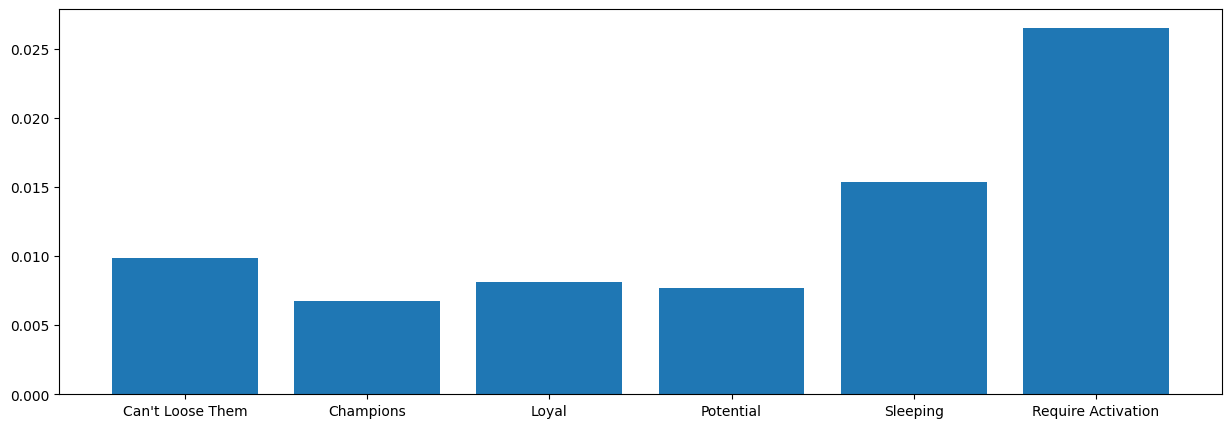

In [61]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);

In [ ]:
# cleanup spark instance
spark.stop()

In [ ]:
#from annoy import AnnoyIndex
#from tqdm import tqdm
#
#with Timer() as test_time:
##

    # Extract user and item factors
#    user_factors = model.userFactors
#    item_factors = model.itemFactors

    # Create an Annoy index with the same number of dimensions as the item factors
#    embedding_dimension = len(item_factors.select("features").first()[0])
#    annoy_index = AnnoyIndex(embedding_dimension, 'angular')

    # Add item factors to the Annoy index
#    item_factors_list = item_factors.select("id", "features").collect()
#    for item in item_factors_list:
#        annoy_index.add_item(item["id"], item["features"])

    # Build the Annoy index
#    annoy_index.build(100) # You can adjust the number of trees to balance search speed and accuracy

    # Find top K recommendations for each user
#    K = 100
#    top_k_recommendations = {}

#    for user in tqdm(user_factors.select("id", "features").collect()):
#        user_id = user["id"]
#        user_embedding = user["features"]
#        nearest_item_ids = annoy_index.get_nns_by_vector(user_embedding, K)
#        top_k_recommendations[user_id] = nearest_item_ids

In [ ]:
#with Timer() as test_time:

    # Get the cross join of all user-item pairs and score them.
#    users = train.select(COL_USER).distinct()
#    items = train.select(COL_ITEM).distinct()
#    user_item = users.crossJoin(items)
#    dfs_pred = model.transform(user_item)

    # Remove seen items.
#    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
#        train.alias("train"),
#        (dfs_pred[COL_USER] == train[COL_USER]) & (dfs_pred[COL_ITEM] == train[COL_ITEM]),
#        how='outer'
#    )

    # train.{col_rating} will be null on the previous step, if this pair was not seen before. These are the entries of interest to us.
#    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{COL_RATING}"].isNull()) \
#        .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

    # In Spark, transformations are lazy evaluation
    # Use an action to force execute and measure the test time 
#    top_all.cache().count()

#print("Took {} seconds for prediction.".format(test_time.interval))